In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

import config as cf
rl = lambda x: x.replace('\\', '/')
print(f'VITABSET_TRAIN_IMAGE_ROOT = "{rl(cf.VITABSET_TRAIN_IMAGE_ROOT)}"')
print(f'VITABSET_TRAIN_JSON = "{rl(cf.VITABSET_TRAIN_JSON)}"')
print(f'VITABSET_VAL_IMAGE_ROOT = "{rl(cf.VITABSET_VAL_IMAGE_ROOT)}"')
print(f'VITABSET_VAL_JSON = "{rl(cf.VITABSET_VAL_JSON)}"')
print(f'VITABSET_TEST_IMAGE_ROOT = "{rl(cf.VITABSET_TEST_IMAGE_ROOT)}"')
print(f'VITABSET_TEST_JSON = "{rl(cf.VITABSET_TEST_JSON)}"')
print(f'STRUCTURE_VOCAB_FILE = "{rl(cf.STRUCTURE_VOCAB_FILE)}"')

VITABSET_TRAIN_IMAGE_ROOT = "F:/data/vitabset/train"
VITABSET_TRAIN_JSON = "F:/data/vitabset/train.bz2"
VITABSET_VAL_IMAGE_ROOT = "F:/data/vitabset/val"
VITABSET_VAL_JSON = "F:/data/vitabset/val.bz2"
VITABSET_TEST_IMAGE_ROOT = "F:/data/vitabset/test"
VITABSET_TEST_JSON = "F:/data/vitabset/test.bz2"
STRUCTURE_VOCAB_FILE = "d:/BIG Projects/Python/ETV/src/data/structure_vocab.txt"


In [2]:
from mmengine.config import Config

# Load config
cfg = Config.fromfile('../src/configs/etv_concat_resnetex_ranger.py')
print(cfg.pretty_text)

PAD = 97
STRUCTURE_VOCAB_FILE = 'd:/BIG Projects/Python/ETV/src/data/structure_vocab.txt'
VITABSET_TEST_IMAGE_ROOT = 'F:/data/vitabset/test'
VITABSET_TEST_JSON = 'F:/data/vitabset/test.bz2'
VITABSET_TRAIN_IMAGE_ROOT = 'F:/data/vitabset/train'
VITABSET_TRAIN_JSON = 'F:/data/vitabset/train.bz2'
VITABSET_VAL_IMAGE_ROOT = 'F:/data/vitabset/val'
VITABSET_VAL_JSON = 'F:/data/vitabset/val.bz2'
alphabet_len = 94
custom_imports = dict(
    allow_failed_imports=False,
    imports=[
        'datasets.table_dataset',
        'datasets.transforms.load_tokens',
        'datasets.transforms.pack_inputs',
        'datasets.transforms.table_pad',
        'datasets.transforms.table_resize',
        'datasets.transforms.bbox_encode',
        'datasets.transforms.pad_data',
        'models.backbones.resnet_extra',
        'models.backbones.table_resnet_extra',
        'models.decoders.table_master_concat_decoder',
        'models.dictionaries.table_master_dictionary',
        'models.encoders.positional_e

In [3]:
from models.backbones.resnet_extra import ResNetExtra
from models.decoders.table_master_concat_decoder import TableMasterConcatDecoder
from models.dictionaries.table_master_dictionary import TableMasterDictionary
from models.losses.master_tf_loss import MasterTFLoss
from models.metrics.teds_metric import TEDSMetric
from models.postprocessors.table_master_postprocessor import TableMasterPostprocessor
from datasets.table_dataset import PubTabNetDataset
from datasets.transforms.table_resize import TableResize
from datasets.transforms.table_pad import TablePad
from datasets.transforms.load_tokens import LoadTokens
from datasets.transforms.pack_inputs import PackInputs
from optimizer.ranger import Ranger
from mmocr.utils import register_all_modules
register_all_modules()

In [4]:
from mmocr.registry import DATASETS
dataset_config = cfg.train_dataloader.dataset.copy()
dataset_pipeline = dataset_config['pipeline']
dataset_config['pipeline'] = []
dataset_config['max_data'] = 100
# Build dataset
dataset = DATASETS.build(dataset_config)

In [5]:

# Kiểm tra 1 sample đầu tiên
sample = dataset[1]
print(sample)


{'img_path': 'F:/data/vitabset/train\\143530.png', 'sample_idx': 1, 'instances': [{'tokens': ['<thead>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</thead>', '<tbody>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</tbody>'], 'type': 'structure'}, {'tokens': ['N', 'ộ', 'i', ' ', 'd', 'u', 'n', 'g'], 'cell_id': 0, 'type': 'content', 'bbox': [10, 9, 92, 38]}, {'tokens': ['V', 'à', 'n', 'g'], 'cell_id': 1, 'type': 'content', 'bbox': [196, 9, 247, 38]}, {'tokens': ['B', 'ạ', 'c'], 'cell_id': 2, 'type': 'content', 'bbox': [420, 9, 459, 38]}, {'tokens': ['Đ', 'ồ', 'n', 'g'], 'cell_id': 3, 'type': 'content', 'bbox': [625, 9, 678, 38]}, {'tokens': ['5', 'x', '

In [6]:
import random
from mmengine.dataset import Compose
pipeline = Compose(dataset_pipeline)
print(dataset_pipeline)

[{'type': 'LoadImageFromFile'}, {'type': 'LoadTokens', 'with_structure': True, 'with_cell': False, 'max_structure_token_len': 600, 'max_cell_token_len': 600}, {'type': 'TableResize', 'keep_ratio': True, 'long_size': 480}, {'type': 'TablePad', 'size': (480, 480), 'pad_val': 0, 'return_mask': True, 'mask_ratio': (8, 8)}, {'type': 'PackInputs', 'keys': ['img'], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'meta_keys': ('bboxes', 'masks', 'filename', 'ori_shape', 'img_shape', 'scale_factor', 'ori_filename', 'pad_shape', 'valid_ratio')}, {'type': 'BboxEncode'}, {'type': 'PadData', 'dictionary': {'type': 'TableMasterDictionary', 'dict_file': 'd:/BIG Projects/Python/ETV/src/data/structure_vocab.txt', 'with_padding': True, 'with_unknown': True, 'same_start_end': True, 'with_start': True, 'with_end': True}, 'max_seq_len': 600, 'max_bbox_len': 600, 'pad_with': 'auto'}]


In [7]:
def print_dict(d, indent=2):
    """Prints a dictionary in a readable format."""
    print(' ' * (indent - 2) + '{')
    for key, value in d.items():
        print(' ' * indent + f"{key}: ", end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent + 2)
        elif isinstance(value, list):
            if value and all(isinstance(item, dict) for item in value):
                print('[')
                for item in value:
                    print_dict(item, indent + 2)
                print(' ' * indent + ']')
            else:
                print(value)
        else:
            print(value)
    print(' ' * (indent - 2) + '}')

import random
print_dict(dataset[random.randint(0, len(dataset) - 1)])

{
  img_path: F:/data/vitabset/train\143541.png
  sample_idx: 13
  instances: [
  {
    tokens: ['<thead>', '<tr>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</thead>', '<tbody>', '<tr>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</tbody>']
    type: structure
  }
  {
    tokens: ['D', 'i', 'ễ', 'n', ' ', 'v', 'i', 'ê', 'n']
    cell_id: 0
    type: content
    bbox: [32, 8, 128, 36]
  }
  {
    tokens: ['V', 'a', 'i', ' ', 'd', 'i', 'ễ', 'n']
    cell_id: 1
    type: content
    bbox: [187, 8, 274, 36]
  }
  {
    tokens: ['<b>', 'L', 'ỗ', ' ', 'C', 'h', 'ấ', 'n', ' ', 'T', 'h', 'u', 'ậ', 'n', '</b>']
    cell_id: 2
    type: content
    bbox: [8, 42, 143, 70]
  }
  {
    tokens: ['N', 'g', 'à', 'i', ' ', 'T', 'ă', 'n', 'g']
    c

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def is_equal(a, b):
    if isinstance(a, (np.ndarray, torch.Tensor)) and isinstance(b, (np.ndarray, torch.Tensor)):
        if isinstance(a, torch.Tensor):
            return torch.equal(a, b)
        return np.array_equal(a, b)
    return a == b

# sample = dataset[random.randint(0, len(dataset) - 1)].copy()
sample = dataset[80].copy()

print("\n=== Original Sample ===")
print_dict(sample)

for i, transform in enumerate(pipeline.transforms):
    print(f"\n=== Step {i+1}: {transform.__class__.__name__} ===")
    print(f"Transform: {transform}")
    print(f"Before: {list(sample.keys())}")
    
    old_sample = sample.copy()
    sample = transform(sample)
    
    print(f"After: {list(sample.keys())}")
    diff = {k: v for k, v in sample.items() if k not in old_sample or not is_equal(old_sample[k], v)}
    print_dict(diff, indent=2)


=== Original Sample ===
{
  img_path: F:/data/vitabset/train\143609.png
  sample_idx: 80
  instances: [
  {
    tokens: ['<thead>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</thead>', '<tbody>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '<tr>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '<td>', '</td>', '</tr>', '</tbody>']
    type: structure
  }
  {
    tokens: ['N', 'ă', 'm']
    cell_id: 0
    type: content
    bbox: [9, 13, 52, 40]
  }
  {
    tokens: ['T', 'ê', 'n', ' ', 'p', 'h', 'i', 'm']
    cell_id: 1
    type: content
    bbox: [224, 13, 300, 40]
  }
  {
    tokens: ['V', 'a', 'i']
    cell_id: 2
    type: content
    bbox: [514, 13, 547, 40]
  }
  {
    tokens: ['C', 'h', 'ú', ' ', 't', 'h', 'í', 'c', 'h']
    cell_id: 3
    type: content
    bbox: [649, 13, 727, 40]
  }
  {
    tokens: ['2', '0

In [9]:
data = dataset[80].copy()
idx = [s.get('cell_id') for s in data['instances'] if s.get('type') == 'content']
print(f"Cell IDs: {idx}")

Cell IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


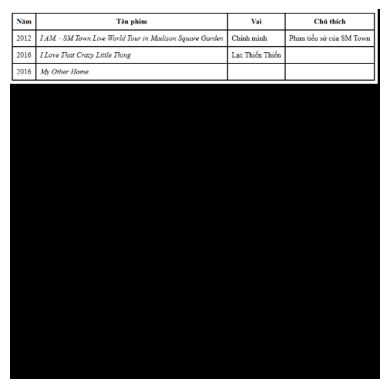

<TableMasterDataSample(

    META INFORMATION
    img_shape: (480, 480)
    scale_factor: (0.6030341340075853, 0.6024844720496895)
    have_normalized_bboxes: True
    have_padded_bboxes: True
    ori_filename: None
    valid_ratio: 1
    padded_bboxes: tensor([[0.0000, 0.0000, 0.0000, 0.0000],
                [0.0000, 0.0000, 0.0000, 0.0000],
                [0.0635, 0.0552, 0.0896, 0.0562],
                ...,
                [0.0000, 0.0000, 0.0000, 0.0000],
                [0.0000, 0.0000, 0.0000, 0.0000],
                [0.0000, 0.0000, 0.0000, 0.0000]])
    img_norm_cfg: 
        mean: [0.5, 0.5, 0.5]
        std: [0.5, 0.5, 0.5]
    ori_shape: (161, 791)
    masks: array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
               1, 1, 0, 0, 0, 0])
    have_padded_indexes: True
    filename: None
    pad_shape: (480, 480, 3)
    padded_masks: tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
                1., 0., 0., 0., 1.

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_normalized_img(img, mean, std):
    """Hiển thị ảnh đã normalize"""
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    
    if len(img.shape) == 4:
        img = img[0]
    
    # Denormalize: (img * std) + mean
    # Reshape mean và std để match với image shape (C,H,W)
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    denorm = (img * std) + mean
    denorm = (denorm - denorm.min()) / (denorm.max() - denorm.min()) # Chuẩn hóa lại về khoảng [0, 1]
    
    # Chuyển từ (C,H,W) sang (H,W,C) để hiển thị
    denorm = np.transpose(denorm, (1, 2, 0))
    
    plt.imshow(denorm)
    plt.axis('off') 
    plt.show()

img, instances = sample['inputs'], sample['data_samples']
mean = instances.metainfo['img_norm_cfg']['mean']
std = instances.metainfo['img_norm_cfg']['std']
show_normalized_img(img, mean, std)
print(instances)